In [556]:
# Import section libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, timedelta
from matplotlib.pyplot import rcParams
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, adfuller, pacf

In [839]:
# Some settings

# PATH

PATH = '../../Raw Data sets/Sauti Africa Market Monitoring/eac-ratin.csv'

# Size of plottings

rcParams['figure.figsize'] = 25,6

In [558]:
# Importing the data

prices = pd.read_csv(PATH)

In [559]:
prices.head()

,Market,Product,Country,Date,Retail (MT),Wholesale (MT),Currency
0,Bujumbura,Maize,Burundi,10/4/2011,0,548798,BIF
1,Bujumbura,Maize,Burundi,10/5/2011,0,549000,BIF
2,Bujumbura,Maize,Burundi,10/6/2011,0,498970,BIF
3,Bujumbura,Maize,Burundi,10/7/2011,0,549299,BIF
4,Bujumbura,Maize,Burundi,10/10/2011,0,549872,BIF


In [560]:
# As a Start I'm choosing just Maize prices from Lira market.

lira = prices[prices['Market'] == 'Lira']
print(lira.shape)

(2397, 7)


In [561]:
# There are duplicated dates!

lira[['Date']].nunique()

Date    1949
dtype: int64

In [562]:
# Drop duplicated rows in terms of Dates.

lira = lira.drop(labels=lira[lira.duplicated(['Date'], keep='first')].index, axis=0)

In [563]:
# Set the index to dates and turn the prices from MT to kg prices.

lira['Date'] = pd.to_datetime(lira['Date'], infer_datetime_format=True)
lira = lira.set_index('Date')
lira = lira[['Wholesale (MT)']].astype(float) / 1000
lira = lira[lira.index >= '2010-12-31']
lira.head()

,Wholesale (MT)
Date,
2011-03-04,499.489
2011-03-07,499.655
2011-03-10,500.561
2011-03-15,494.353
2011-03-21,498.928


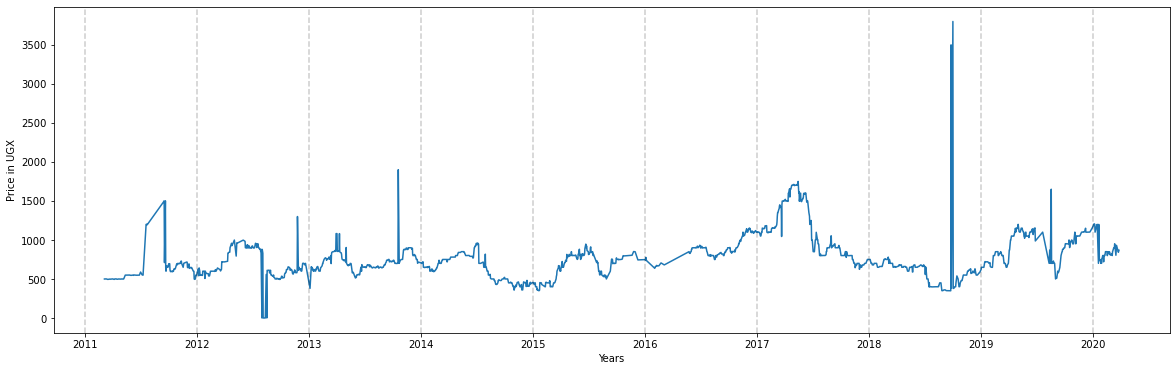

In [564]:
# First plot of the (collected) data.

timeseries_prices = plt.plot(lira['Wholesale (MT)'], label = 'Maize Price')

for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()



In [565]:
# Building a dataframe with all the possible dates between start='2/27/2011', end='3/28/2020'.

dummy = pd.DataFrame()
dummy['dates'] = pd.date_range(start='2/23/2011', end='3/29/2020')
dummy = dummy.set_index('dates')
lira = dummy.merge(lira, how='outer', left_index=True, right_index=True)
print(dummy.shape)
lira.shape

(3323, 0)


(3323, 1)

In [566]:
# Finding the outliers.

z = np.abs(stats.zscore(lira['Wholesale (MT)'], nan_policy='omit'))


dates_to_drop = [lira.iloc[i:i+1,:].index[0] for i in list(np.where(z>4)[0])]
dates_to_drop = dates_to_drop + list(lira[lira['Wholesale (MT)'] <= 0].index)
lira = lira.drop(dates_to_drop, axis=0)
lira

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


,Wholesale (MT)
2011-02-23,NaN
2011-02-24,NaN
2011-02-25,NaN
2011-02-26,NaN
2011-02-27,NaN
...,...
2020-03-25,842.071
2020-03-26,NaN
2020-03-27,868.066
2020-03-28,NaN


In [567]:
# Divide the dates by week. The number 1 means Sunday.

lira['mean_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=1).mean()
# lira['std_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=2).std()

lira['number_of_day'] = [i%7 +1 for i in range(len(lira))]

# lira['difference'] = np.where(lira['Wholesale (MT)'] >= (lira['mean_price_7days'] + 2*lira['std_price_7days']), 'Yes','No' )
print(lira.shape)
lira.head(25)

(3313, 3)


,Wholesale (MT),mean_price_7days,number_of_day
2011-02-23,NaN,NaN,1
2011-02-24,NaN,NaN,2
2011-02-25,NaN,NaN,3
2011-02-26,NaN,NaN,4
2011-02-27,NaN,NaN,5
2011-02-28,NaN,NaN,6
2011-03-01,NaN,NaN,7
2011-03-02,NaN,NaN,1
2011-03-03,NaN,NaN,2
2011-03-04,499.489,499.489000,3


In [568]:
lira.tail(25)

,Wholesale (MT),mean_price_7days,number_of_day
2020-03-05,800.240,808.239000,6
2020-03-06,847.486,822.575667,7
2020-03-07,NaN,822.575667,1
2020-03-08,NaN,822.575667,2
2020-03-09,NaN,822.575667,3
2020-03-10,899.079,848.935000,4
2020-03-11,NaN,848.935000,5
2020-03-12,900.343,882.302667,6
2020-03-13,950.518,916.646667,7
2020-03-14,NaN,916.646667,1


In [569]:
# looking for weeks with no values at all.

lira[lira['number_of_day'] == 7]['mean_price_7days'][lira[lira['number_of_day'] == 7]['mean_price_7days'].isnull()]

2011-03-01   NaN
2011-08-02   NaN
2011-08-09   NaN
2011-08-16   NaN
2011-08-23   NaN
2011-08-30   NaN
2011-09-06   NaN
2012-05-22   NaN
2013-01-01   NaN
2015-09-09   NaN
2015-11-04   NaN
2015-11-11   NaN
2015-11-18   NaN
2015-12-16   NaN
2015-12-23   NaN
2015-12-30   NaN
2016-01-20   NaN
2016-01-27   NaN
2016-03-02   NaN
2016-03-16   NaN
2016-03-23   NaN
2016-03-30   NaN
2016-04-06   NaN
2016-04-13   NaN
2016-04-20   NaN
2016-04-27   NaN
2016-05-04   NaN
2016-05-11   NaN
2016-05-18   NaN
2019-07-05   NaN
2019-07-12   NaN
2019-07-19   NaN
2019-08-02   NaN
Name: mean_price_7days, dtype: float64

In [768]:
# Fitting the data into a data Frame with only Sundays.

weekly_lira = pd.DataFrame()

# weekly_lira = pd.DataFrame(lira[lira['number_of_day'] == 7]['mean_price_7days'].interpolate())
weekly_lira['dates'] = pd.date_range(start='2011-03-06', periods=round(len(lira)/360*52,0), freq='W')
weekly_lira = weekly_lira.set_index('dates')

In [769]:
# Merge the info to have a DataFrame with only weekly means.

weekly_lira = weekly_lira.merge(lira, how='inner', left_index=True, right_index=True)
weekly_lira = weekly_lira[['mean_price_7days']].interpolate()

# Need to be sure the last week has been completed.

last_day_filled = lira[lira['Wholesale (MT)'].isnull() == False].index[-1]

if weekly_lira.index[-1] < last_day_filled:
    pass
else:
    weekly_lira = weekly_lira.drop(labels = weekly_lira.index[-1], axis=0)

weekly_lira

,mean_price_7days
2011-03-06,499.489000
2011-03-13,500.108000
2011-03-20,494.353000
2011-03-27,498.218750
2011-04-03,500.078500
...,...
2020-02-23,836.499250
2020-03-01,824.239667
2020-03-08,822.575667
2020-03-15,916.646667


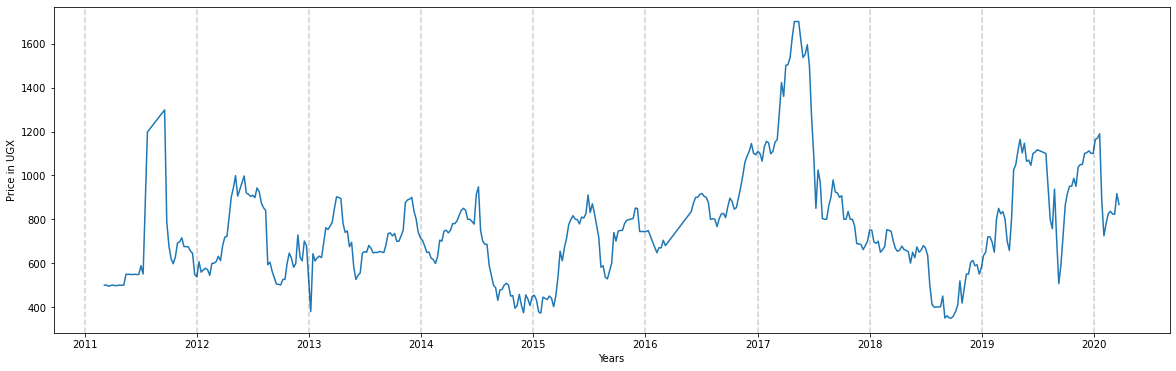

In [770]:
# Plot of the weekly means.

timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


### Work on the bands of stress

In [771]:
def build_bands_year_lag(dataframe):
    
    year_lag_bands = dataframe.copy()
    year_lag_bands['expected_mean'] = None
    year_lag_bands['normal_limit'] = None
    year_lag_bands['stress_limit'] = None
    year_lag_bands['alert_limit'] = None
        
    for date in dataframe.index[52:]:
        
        try:
            
            window = dataframe[:date - timedelta(weeks=48) ]
            means = window.groupby(lambda d: d.month).mean()
            stds = window.groupby(lambda d: d.month).std()
            year_lag_bands.iloc[len(dataframe.loc[:date]),1] =  means.loc[int(str(date)[5:7])][0]
            year_lag_bands.iloc[len(dataframe.loc[:date]),2] =  means.loc[int(str(date)[5:7])][0] + 0.25 * stds.loc[int(str(date)[5:7])][0]
            year_lag_bands.iloc[len(dataframe.loc[:date]),3] =  means.loc[int(str(date)[5:7])][0] + stds.loc[int(str(date)[5:7])][0]
            year_lag_bands.iloc[len(dataframe.loc[:date]),4] =  means.loc[int(str(date)[5:7])][0] +  2 * stds.loc[int(str(date)[5:7])][0]
        
        except:
            pass
     
    
    return year_lag_bands[53:]

year_lag_bands = build_bands_year_lag(weekly_lira)

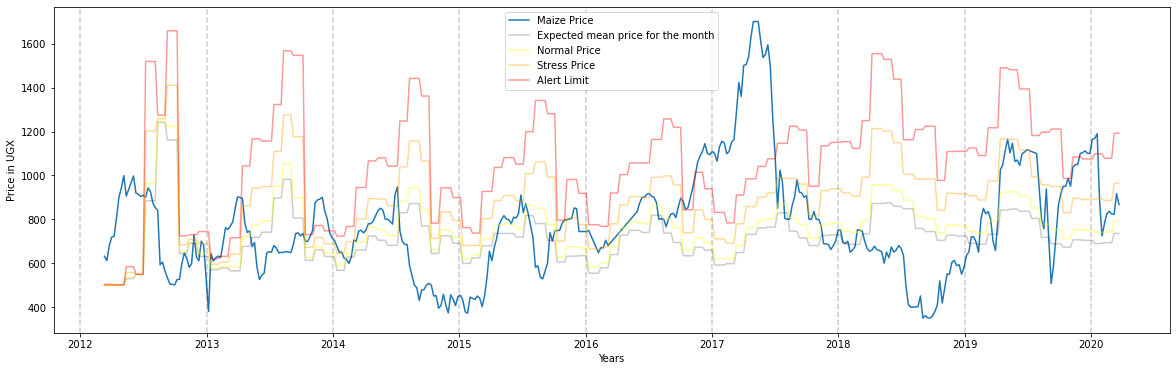

In [772]:
plt.plot(year_lag_bands.iloc[:,0], label = 'Maize Price')
plt.plot(year_lag_bands.iloc[:,1], label = 'Expected mean price for the month', color='k', alpha=0.2)
plt.plot(year_lag_bands.iloc[:,2], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(year_lag_bands.iloc[:,3], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(year_lag_bands.iloc[:,4], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2012,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()

In [889]:
def build_bands_window_lag(dataframe,length):
    
    window_lag_bands = dataframe[length:].copy()
    window_lag_bands['past_mean'] = None
    window_lag_bands['normal_limit'] = None
    window_lag_bands['stress_limit'] = None
    window_lag_bands['alert_limit'] = None
        
    window_lag_bands['past_mean'] = dataframe.iloc[:,0].rolling(window=length,min_periods=1).mean().values[length -1: -1]
    window_lag_bands['normal_limit'] = dataframe.iloc[:,0].rolling(window=length,min_periods=1).mean().values[length -1: -1] + 0.25 * dataframe.iloc[:,0].rolling(window=length,min_periods=1).std().values[length -1: -1]
    window_lag_bands['stress_limit'] = dataframe.iloc[:,0].rolling(window=length,min_periods=1).mean().values[length -1: -1] + dataframe.iloc[:,0].rolling(window=length,min_periods=1).std().values[length -1: -1]
    window_lag_bands['alert_limit'] = dataframe.iloc[:,0].rolling(window=length,min_periods=1).mean().values[length -1: -1] + 2 * dataframe.iloc[:,0].rolling(window=length,min_periods=1).std().values[length -1: -1]

     
    
    return window_lag_bands#[length+1:]

fourweeklag_bands = build_bands_window_lag(weekly_lira,4)


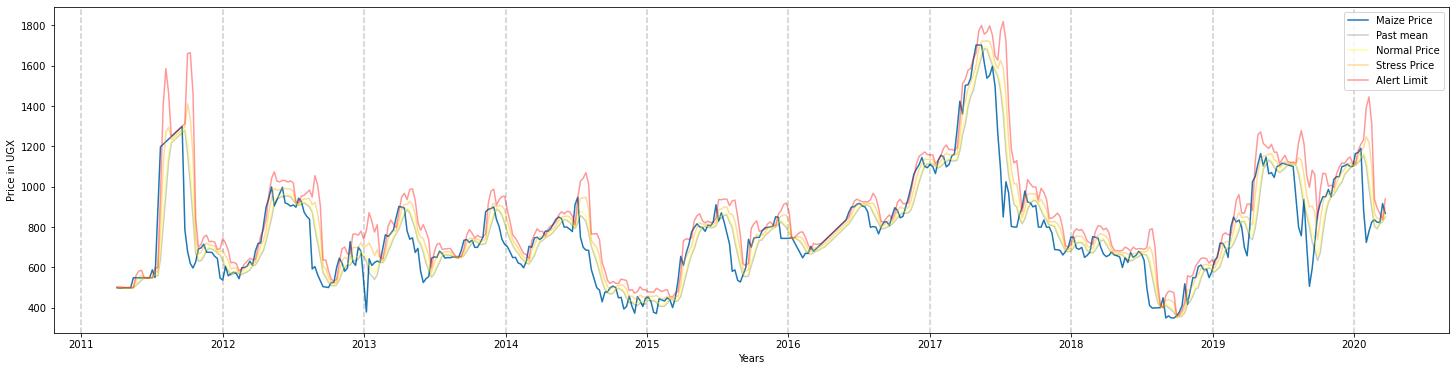

In [890]:
plt.plot(fourweeklag_bands.iloc[:,0], label = 'Maize Price')
plt.plot(fourweeklag_bands.iloc[:,1], label = 'Past mean', color='k', alpha=0.2)
plt.plot(fourweeklag_bands.iloc[:,2], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(fourweeklag_bands.iloc[:,3], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(fourweeklag_bands.iloc[:,4], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()

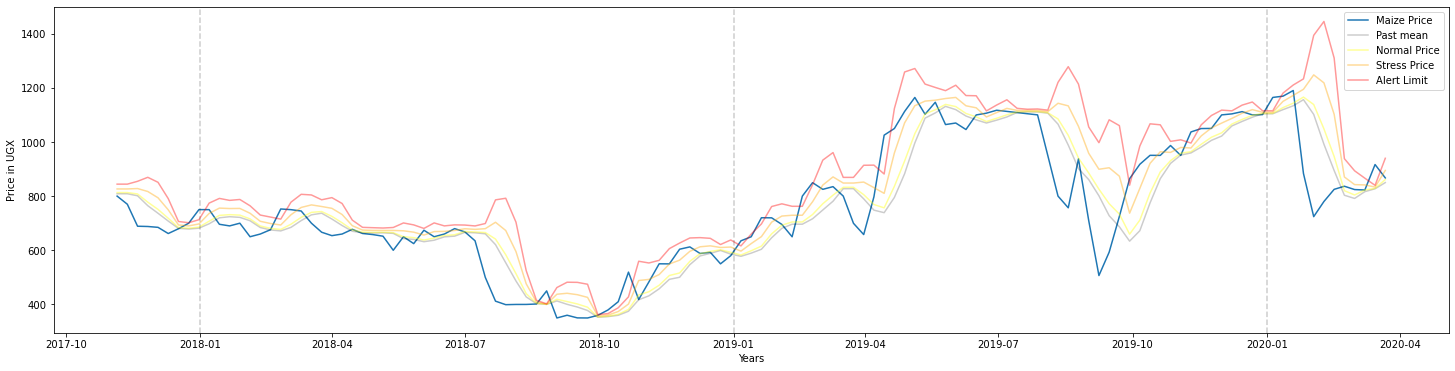

In [896]:
plt.plot(fourweeklag_bands.iloc[-125:,0], label = 'Maize Price')
plt.plot(fourweeklag_bands.iloc[-125:,1], label = 'Past mean', color='k', alpha=0.2)
plt.plot(fourweeklag_bands.iloc[-125:,2], label = 'Normal Price', color='yellow', alpha=0.4)
plt.plot(fourweeklag_bands.iloc[-125:,3], label = 'Stress Price', color='orange', alpha=0.4)
plt.plot(fourweeklag_bands.iloc[-125:,4], label = 'Alert Limit', color='red', alpha=0.4)

for year in range(2018,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.legend(loc='best')
plt.show()

In [897]:
# Augmented Dickey-Fuller test


'''
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root is that it determines how strongly a time series is defined by a trend.
The more negative the statistic is, the more likely to reject the null hypothesis, this mean, 
    the data has a unit root and is non-stationary. It has some time dependency.
'''


result_adft = adfuller(weekly_lira['mean_price_7days'])
print(f'ADF Statistic: {round(result_adft[0],4)}')
print(f'p-value: {round(result_adft[1],4)}')
print('Critical Values:')
for key, value in result_adft[4].items():
    print(f'{key}: {round(value,4)}')

ADF Statistic: -3.7517
p-value: 0.0034
Critical Values:
1%: -3.4443
5%: -2.8677
10%: -2.57


The statistic is lower than all the critical values, so I reject the Null Hypothesis with a confidence of 99%, meaning that the Time Series is stationary.

## ACF 

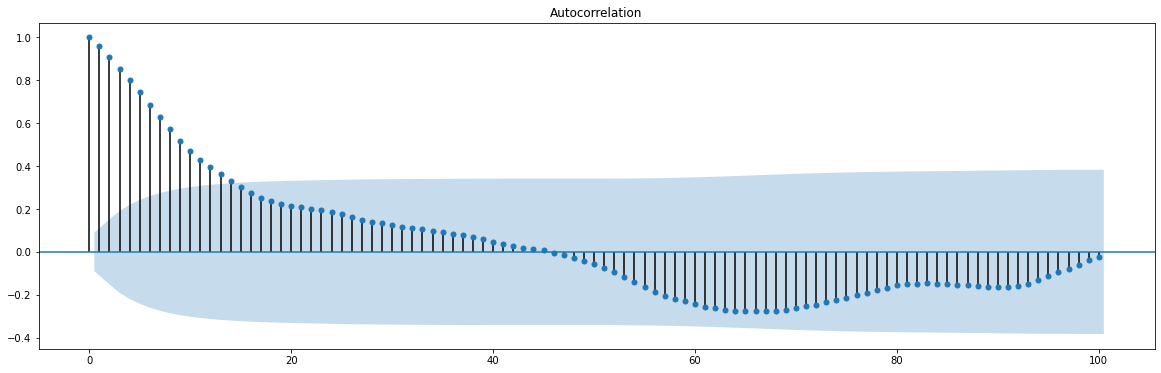

In [574]:
acf_plot = plot_acf(weekly_lira['mean_price_7days'], lags=100)

## PACF

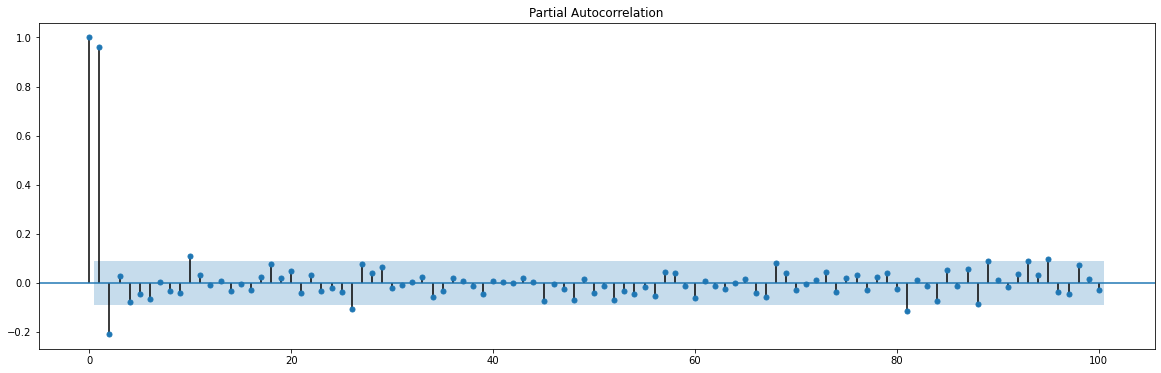

In [575]:
pacf_plot = plot_pacf(weekly_lira['mean_price_7days'], lags=100)

In [576]:
# From previous plots, we can imagine a AR(4) at least will be needed.
# Run a Order select method to get a better selection.

res = sm.tsa.arma_order_select_ic(weekly_lira['mean_price_7days'], ic='aic', trend='c')
res.aic_min_order

C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2)

## SARIMA(4,0,2,8)

In [603]:
# Create the model

premodel = sm.tsa.SARIMAX(weekly_lira['mean_price_7days'], seasonal_order=(4,0,2,8))
model = premodel.fit()

model.summary()


C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                       mean_price_7days   No. Observations:                  473
Model:             SARIMAX(1, 0, 0)x(4, 0, [1, 2], 8)   Log Likelihood               -2663.953
Date:                                Wed, 13 May 2020   AIC                           5343.907
Time:                                        20:07:58   BIC                           5377.180
Sample:                                    03-06-2011   HQIC                          5356.994
                                         - 03-22-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9977      0.003    369.760      0.000       0.992       1.003
ar.S.L8        1.3537      0.358      3.777      0.000       0.651       2.056
ar.S.L16      -0.5865      0.335     -1.753      0.080      -1.242       0.069
ar.S.L24       0.0728      0.100      0.728      0.467      -0.123       0.269
ar.S.L32      -0.1022      0.061     -1.676      0.094      -0.222       0.017
ma.S.L8       -1.3874      0.358     -3.876      0.000      -2.089      -0.686
ma.S.L16       0.5864      0.337      1.742      0.082      -0.073       1.246
sigma2      4358.1676    132.310     32.939      0.000    4098.845    4617.490
===================================================================================
Ljung-Box (Q):                       55.04   Jarque-Bera (JB):              2197.86
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.86
Prob(H) (two-sided):                  0.88   Kurtosis:                        13.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [604]:
# Forecastings

fcast = model.get_forecast(steps=10)
fcast.summary_frame()

mean_price_7days,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-03-29,863.792122,66.016419,734.402318,993.181926
2020-04-05,847.342182,93.253867,664.567962,1030.116403
2020-04-12,855.643635,114.080851,632.049276,1079.237994
2020-04-19,862.795552,131.577848,604.907709,1120.683395
2020-04-26,866.712474,146.939591,578.716167,1154.708781
2020-05-03,851.461975,160.779576,536.339797,1166.584153
2020-05-10,831.291526,173.462693,491.310894,1171.272158
2020-05-17,844.532414,185.226984,481.494196,1207.570632
2020-05-24,844.859461,195.512935,461.661149,1228.057773
2020-05-31,824.403733,205.240254,422.140228,1226.667238


In [605]:
# Creating the bands for classification prices.

alert_bands = fcast.summary_frame()

alert_bands['normal'] = alert_bands['mean'] + 0.25 * alert_bands['mean_se']

alert_bands['stress'] = alert_bands['mean'] + alert_bands['mean_se']

alert_bands['crisis'] = alert_bands['mean'] + 2 * alert_bands['mean_se']

alert_bands

mean_price_7days,mean,mean_se,mean_ci_lower,mean_ci_upper,normal,stress,crisis
2020-03-29,863.792122,66.016419,734.402318,993.181926,880.296227,929.808541,995.824960
2020-04-05,847.342182,93.253867,664.567962,1030.116403,870.655649,940.596049,1033.849916
2020-04-12,855.643635,114.080851,632.049276,1079.237994,884.163848,969.724486,1083.805337
2020-04-19,862.795552,131.577848,604.907709,1120.683395,895.690014,994.373400,1125.951248
2020-04-26,866.712474,146.939591,578.716167,1154.708781,903.447372,1013.652066,1160.591657
2020-05-03,851.461975,160.779576,536.339797,1166.584153,891.656869,1012.241551,1173.021126
2020-05-10,831.291526,173.462693,491.310894,1171.272158,874.657199,1004.754219,1178.216913
2020-05-17,844.532414,185.226984,481.494196,1207.570632,890.839160,1029.759399,1214.986383
2020-05-24,844.859461,195.512935,461.661149,1228.057773,893.737695,1040.372396,1235.885332
2020-05-31,824.403733,205.240254,422.140228,1226.667238,875.713796,1029.643987,1234.884240


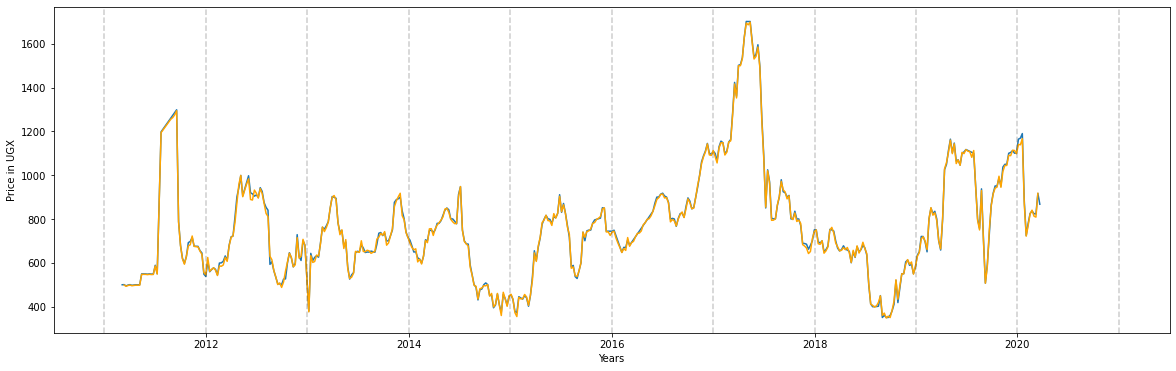

In [606]:
# 

timeseries_prices = plt.plot(weekly_lira['mean_price_7days'], label = 'Maize Price')
plt.plot(model.predict(1,472).shift(-1), label='predictions', color='orange')

for year in range(2011,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()



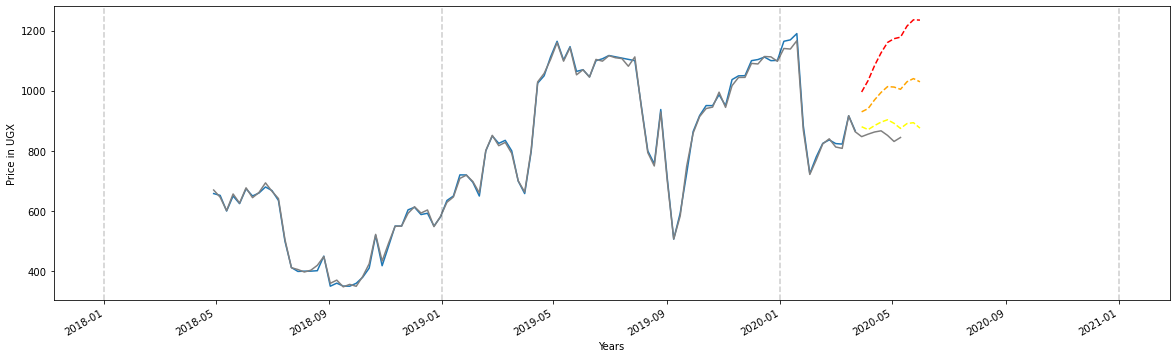

In [607]:
timeseries_prices = plt.plot(weekly_lira['mean_price_7days'][-100:], label = 'Maize Price')
plt.plot(model.predict(str(weekly_lira['mean_price_7days'][-100:].index[0])[:10],480).shift(-1), label='predictions', color='gray')

alert_bands['normal'].plot(color='yellow', style='--')
alert_bands['stress'].plot(color='orange', style='--')
alert_bands['crisis'].plot(color='red', style='--')

for year in range(2018,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')

plt.show()

# plt.savefig('sarima_maize_alert_crisis_bands_test.png')

## ARMA(4,2)

In [587]:
# Create the model

premodel = ARMA(weekly_lira['mean_price_7days'], order=(4,2))
model = premodel.fit()

model.summary()


C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       mean_price_7days   No. Observations:                  473
Model:                     ARMA(4, 2)   Log Likelihood               -2646.167
Method:                       css-mle   S.D. of innovations             64.865
Date:                Wed, 13 May 2020   AIC                           5308.335
Time:                        19:59:26   BIC                           5341.608
Sample:                    03-06-2011   HQIC                          5321.422
                         - 03-22-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    765.4950     57.709     13.265      0.000     652.387     878.603
ar.L1.mean_price_7days     2.6550      0.068     39.045      0.000       2.522       2.788
ar.L2.mean_price_7days    -2.8472      0.149    -19.142      0.000      -3.139      -2.556
ar.L3.mean_price_7days     1.3915      0.125     11.122      0.000       1.146       1.637
ar.L4.mean_price_7days    -0.2198      0.047     -4.678      0.000      -0.312      -0.128
ma.L1.mean_price_7days    -1.5186      0.054    -28.236      0.000      -1.624      -1.413
ma.L2.mean_price_7days     0.9267      0.051     18.247      0.000       0.827       1.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8644           -0.6706j            1.0941           -0.1050
AR.2            0.8644           +0.6706j            1.0941            0.1050
AR.3            1.0791           -0.0000j            1.0791           -0.0000
AR.4            3.5221           -0.0000j            3.5221           -0.0000
MA.1            0.8194           -0.6385j            1.0388           -0.1054
MA.2            0.8194           +0.6385j            1.0388            0.1054
-----------------------------------------------------------------------------
"""

In [592]:
# Forecasting and building the bands for prices categories.

steps = 12
predictions = pd.DataFrame(model.forecast(steps=steps)).copy().T
predictions = predictions.rename({0:'forecast',1:'stderr',2:'conf_int'}, axis=1)
predictions['dates'] = [weekly_lira.index[-1] + timedelta(weeks=i) for i in range(steps)]
predictions = predictions.set_index('dates')

# predictions['normal'] = predictions['forecast'] + 0.25 * predictions['stderr']

# predictions['stress'] = predictions['forecast'] + predictions['stderr']

# predictions['crisis'] = predictions['forecast'] + 2 * predictions['stderr']


predictions



,forecast,stderr,conf_int
dates,,,
2020-03-22,868.736,64.8651,"[741.6027073561457, 995.86913602684]"
2020-03-29,881.783,98.1885,"[689.33668053628, 1074.2287143051428]"
2020-04-05,888.63,121.247,"[650.9897920265735, 1126.2706348036004]"
2020-04-12,882.621,139.627,"[608.9573929692679, 1156.2846138590348]"
2020-04-19,864.993,156.023,"[559.1936995989389, 1170.7928483566066]"
2020-04-26,841.961,171.203,"[506.40919592628416, 1177.5121789094435]"
2020-05-03,821.131,184.811,"[458.9090719871551, 1183.3536461539186]"
2020-05-10,808.2,196.171,"[423.7108214260862, 1192.6889071183687]"
2020-05-17,804.998,204.928,"[403.3463543725843, 1206.648720733231]"


In [593]:
past_predictions = model.predict(1,len(weekly_lira))

In [594]:
weekly_lira.loc[predictions.index[0]]
# predictions.index[0]

mean_price_7days    867.2305
Name: 2020-03-22 00:00:00, dtype: float64

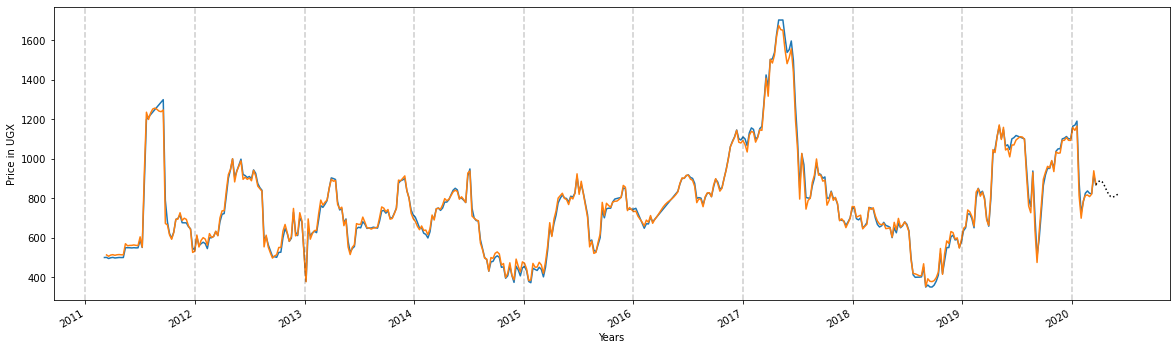

In [595]:
# New Plot with fitted prices, forecast and categorical bands.

timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(past_predictions.shift(-1), label='past predictions')

predictions['forecast'].plot(color='black', style=':')
# predictions['normal'].plot(color='yellow', style='--')
# predictions['stress'].plot(color='orange', style='--')
# predictions['crisis'].plot(color='red', style='--')


for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


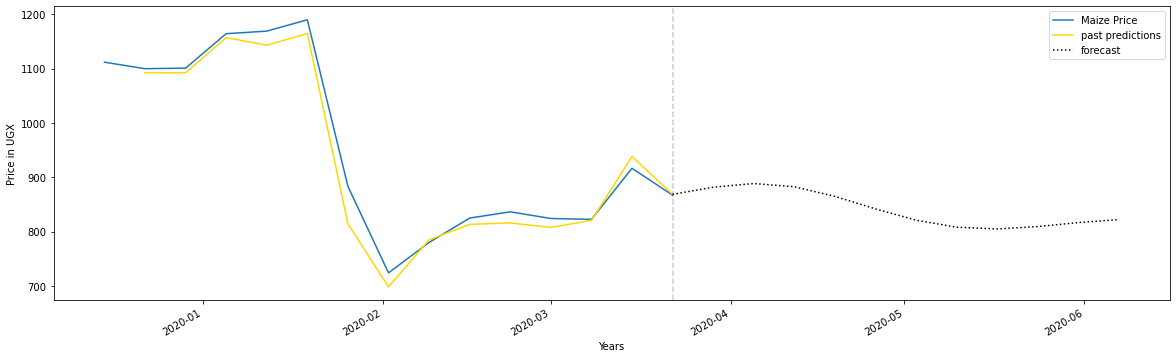

In [597]:

lag = 15

timeseries_prices = plt.plot(weekly_lira['mean_price_7days'][-lag:], label = 'Maize Price')
plt.plot(past_predictions[-lag:].shift(-1), label='past predictions', color='gold')

predictions['forecast'][-lag:].plot(color='black', style=':')
# predictions['normal'][-lag:].plot(color='yellow', style='--', label='begin stress')
# predictions['stress'][-lag:].plot(color='orange', style='--', label='begin alert')
# predictions['crisis'][-lag:].plot(color='red', style='--', label='begin crisis')

plt.axvline(weekly_lira[-1:].index[0], color='k', linestyle='--', alpha=0.2)
# for year in range(int(str(weekly_lira[-lag:].index[0])[:4]),2021):
#     plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Price in UGX')
# plt.savefig('arma_maize_alert_crisis_bands_test.png')
plt.show()

In [542]:
# looking the last prices.

last_seven_days_observed = lira[['Wholesale (MT)']].tail(8)
last_seven_days_observed = last_seven_days_observed[last_seven_days_observed['Wholesale (MT)'].isnull() == False]
last_seven_days_observed['Price Status'] = np.nan

In [545]:
# Labeling the prices of the last 7 observed days.

for date in last_seven_days_observed.index:
    if date <= predictions.index[0]:
        if last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[0]]['normal']:
            last_seven_days_observed['Price Status'] = 'Normal'
        elif last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[0]]['stress']:
            last_seven_days_observed['Price Status'] = 'Stress'
        elif last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[0]]['crisis']:
            last_seven_days_observed['Price Status'] = 'Alert'
        else:
            last_seven_days_observed['Price Status'] = 'Crisis'
    elif date <= predictions.index[1]:
        if last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[1]]['normal']:
            last_seven_days_observed['Price Status'] = 'Normal'
        elif last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[1]]['stress']:
            last_seven_days_observed['Price Status'] = 'Stress'
        elif last_seven_days_observed.loc[date]['Wholesale (MT)'] < predictions.loc[predictions.index[1]]['crisis']:
            last_seven_days_observed['Price Status'] = 'Alert'
        else:
            last_seven_days_observed['Price Status'] = 'Crisis'
    else:
        last_seven_days_observed['Price Status'] = 'Error'

In [546]:
# Results

last_seven_days_observed


,Wholesale (MT),Price Status
2020-03-25,842.071,Normal
2020-03-27,868.066,Normal


In [550]:
lira

,Wholesale (MT),mean_price_7days,number_of_day
2011-02-23,NaN,NaN,1
2011-02-24,NaN,NaN,2
2011-02-25,NaN,NaN,3
2011-02-26,NaN,NaN,4
2011-02-27,NaN,NaN,5
...,...,...,...
2020-03-25,842.071,886.3470,5
2020-03-26,NaN,842.0710,6
2020-03-27,868.066,855.0685,7
2020-03-28,NaN,855.0685,1


# Draft Section

In [462]:
# Draft Libraries import 
from statsmodels.tsa.stattools import arma_order_select_ic

In [463]:
weekly_lira

,mean_price_7days
2011-03-06,499.489000
2011-03-13,500.108000
2011-03-20,494.353000
2011-03-27,498.218750
2011-04-03,500.078500
...,...
2020-02-23,836.499250
2020-03-01,824.239667
2020-03-08,822.575667
2020-03-15,916.646667


In [464]:
weekly_lira.diff(2)

,mean_price_7days
2011-03-06,NaN
2011-03-13,NaN
2011-03-20,-5.136000
2011-03-27,-1.889250
2011-04-03,5.725500
...,...
2020-02-23,56.384500
2020-03-01,-0.759333
2020-03-08,-13.923583
2020-03-15,92.407000


In [465]:
decomposition = seasonal_decompose(weekly_lira)
dir(decomposition)
# decomposition.plot()
decomposition.weights

2011-03-06    1.0
2011-03-13    1.0
2011-03-20    1.0
2011-03-27    1.0
2011-04-03    1.0
             ... 
2020-02-23    1.0
2020-03-01    1.0
2020-03-08    1.0
2020-03-15    1.0
2020-03-22    1.0
Name: weights, Length: 473, dtype: float64

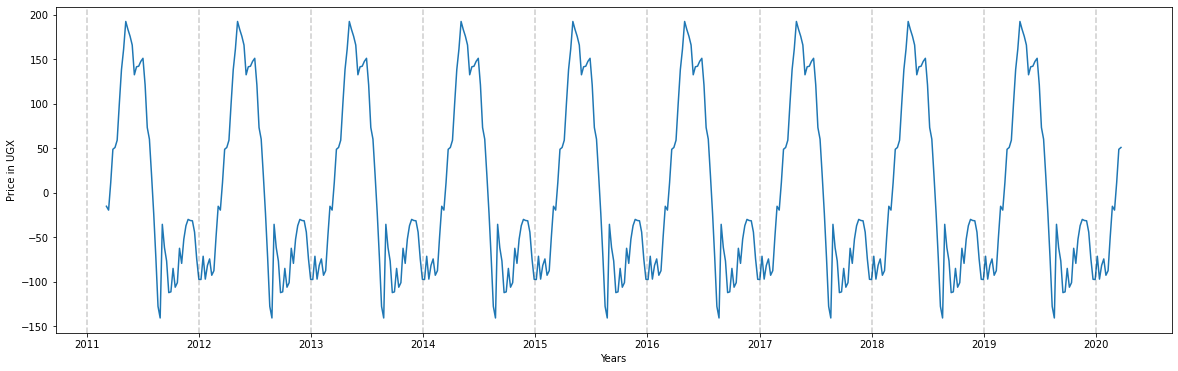

In [466]:
# timeseries_prices = plt.plot(weekly_lira.ewm(halflife=1,min_periods=0,adjust=True).mean(), label = 'Maize Price')
# plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(decomposition.seasonal, label = 'Maize Price')

# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


In [467]:
import statsmodels.api as sm
res = arma_order_select_ic(weekly_lira, max_ar=5, max_ma=3, ic='aic', trend='c')
print(res.aic_min_order)

C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

(4, 2)
